# **1. DATA HANDLING**

# 1.1 Load dataset from Kaggle API

In [26]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

dataset_name = 'vishnu0399/emergency-vehicle-siren-sounds'
data_path = './data'

project_path = os.getcwd()
os.environ['KAGGLE_CONFIG_DIR'] = project_path

kaggle_json_path = os.path.join(project_path, 'kaggle.json')
if not os.path.exists(kaggle_json_path):
    print(f"Warning: kaggle.json not found at {kaggle_json_path}")
    print("Please place your kaggle.json file in the project directory")
    exit(1)
else:
    print(f"Found kaggle.json at {kaggle_json_path}")

api = KaggleApi()

try:
    api.authenticate()
    print("Kaggle API authenticated successfully.")

    print(f"Downloading dataset: {dataset_name} to {data_path}")
    api.dataset_download_files(dataset_name, path=data_path, unzip=True)
except Exception as e:
    print(f"An error occurred: {e}")
    print("Kaggle API authentication failed. Please check your credentials.")


Found kaggle.json at d:\Personal\Dika\tugasKuliah\s4\pddm\sirensoundclassification\kaggle.json
Kaggle API authenticated successfully.
Dataset URL: https://www.kaggle.com/datasets/vishnu0399/emergency-vehicle-siren-sounds


# 1.2 Dataset file loader and preprocessing functions

In [27]:
import wave
import struct
import numpy as np

# === WAV LOADER ===
def read_wav(filename):
    with wave.open(filename, 'rb') as wav_file:
        n_channels, sampwidth, framerate, n_frames, _, _ = wav_file.getparams()
        raw_data = wav_file.readframes(n_frames)
        fmt = "<" + "h" * (n_frames * n_channels)
        data = struct.unpack(fmt, raw_data)
        print(f"📂 Reading File: {filename} (sample rate: {framerate} Hz, total frames: {n_frames})")
        return np.array(data), framerate
    
# Set random seed for reproducibility
np.random.seed(42)

In [28]:
# === TIME DOMAIN ===
def zero_crossing_rate(samples):
    signs = np.sign(samples)
    sign_changes = np.diff(signs)
    zcr = np.count_nonzero(sign_changes) / len(samples)
    print(f"🔹 Zero Crossing Rate: {zcr:.5f}")
    return zcr

def energy(samples):
    en = np.mean(samples**2)
    print(f"🔹 Signal Energy: {en:.2f}")
    return en

In [29]:
from scipy.fft import fft as scipy_fft

# === FREQUENCY DOMAIN (FFT + Dominant Frequency) ===
def fft(samples):
    print(f"🔸 Applying FTT to {len(samples)} samples...")
    fft_result = np.fft.fft(samples)
    magnitudes = np.abs(fft_result)
    return magnitudes

def dominant_freq(magnitudes, sample_rate):
    max_index = np.argmax(magnitudes)
    freq = max_index * sample_rate / len(magnitudes)
    print(f"🔹 Dominant Frequency: {freq:.2f} Hz")
    return freq

In [30]:
# === MFCC ===
def pre_emphasis(signal, coeff=0.97):
    emphasized = np.zeros_like(signal)
    emphasized[0] = signal[0]
    emphasized[1:] = signal[1:] - coeff * signal[:-1]
    return emphasized

def hamming_window(N):
    return np.hamming(N)

def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

def mel_filterbank(n_filters, N_fft, sample_rate):
    low_mel = hz_to_mel(0)
    high_mel = hz_to_mel(sample_rate / 2)
    
    mel_points = np.linspace(low_mel, high_mel, n_filters + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor(hz_points * N_fft / sample_rate).astype(int)
    
    filters = np.zeros((n_filters, N_fft // 2))
    
    for i in range(1, n_filters + 1):
        left = bin_points[i - 1]
        center = bin_points[i]
        right = bin_points[i + 1]
        
        for j in range(left, center):
            if j < filters.shape[1]:
                filters[i - 1, j] = (j - left) / (center - left)
        
        for j in range(center, right):
            if j < filters.shape[1]:
                filters[i - 1, j] = (right - j) / (right - center)
    
    return filters

def apply_filterbanks(magnitudes, filters):
    mag_len = min(len(magnitudes), filters.shape[1])
    magnitudes_truncated = magnitudes[:mag_len]
    filters_truncated = filters[:, :mag_len]
    
    energies = np.dot(filters_truncated, magnitudes_truncated)
    energies = np.log(energies + 1e-10)
    return energies

def dct(signal):
    N = len(signal)
    n = np.arange(N)
    k = np.arange(N).reshape(-1, 1)
    
    dct_matrix = np.cos(np.pi * k * (2 * n + 1) / (2 * N))
    result = np.dot(dct_matrix, signal)
    return result

def mfcc(samples, sample_rate, num_filters=26, num_coeffs=13):
    print("🔸 Counting MFCC...")
    
    emphasized = pre_emphasis(samples)
    
    frame_size = int(0.025 * sample_rate)
    frame = emphasized[:frame_size]
    hamming = hamming_window(len(frame))
    windowed = frame * hamming
    
    spectrum = fft(windowed)
    
    filters = mel_filterbank(num_filters, len(spectrum) * 2, sample_rate)
    
    energies = apply_filterbanks(spectrum, filters)
    
    cepstrals = dct(energies)
    mfccs = cepstrals[:num_coeffs]
    
    print(f"🔹 MFCC (13 coeff): {np.round(mfccs, 2).tolist()}")
    return mfccs.tolist()

In [31]:
# === FEATURE EXTRACTION ===
def extract_features(file_path):
    print(f"\n📥 Extract Features from: {file_path}")
    samples, sample_rate = read_wav(file_path)
    
    zcr = zero_crossing_rate(samples)
    en = energy(samples)
    
    fft_samples = samples[:512] if len(samples) >= 512 else samples
    fft_mags = fft(fft_samples)
    dom_freq = dominant_freq(fft_mags, sample_rate)
    
    mfcc_feats = mfcc(samples, sample_rate)
    
    return [zcr, en, dom_freq] + mfcc_feats

# 1.3 Load, encode label, and split dataset for use

In [32]:
# === LOAD DATASET ===
def load_dataset(folder_path):
    data = []
    labels = []
    print(f"📁 Opening dataset from: {folder_path}")
    
    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)
        if not os.path.isdir(label_folder):
            continue
            
        print(f"\n🗂️ Label: {label}")
        for filename in os.listdir(label_folder):
            if not filename.lower().endswith('.wav'):
                continue
                
            path = os.path.join(label_folder, filename)
            try:
                features = extract_features(path)
                data.append(features)
                labels.append(label)
            except Exception as e:
                print(f"⚠️ Failed to process {path}: {e}")
    
    return np.array(data), labels

def encode_labels(labels):
    unique_labels = list(set(labels))
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    print(f"\n🔢 Label encoding: {label_to_int}")
    encoded_labels = np.array([label_to_int[label] for label in labels])
    return encoded_labels, label_to_int

def train_test_split(data, labels, ratio=0.8, shuffle=True):
    n_train = int(len(data) * ratio)
    
    if shuffle:
        indices = np.random.permutation(len(data))
        train_indices = indices[:n_train]
        test_indices = indices[n_train:]
        print(f"🔄 Split data (shuffled): {n_train} train, {len(data) - n_train} test")
        return (data[train_indices], labels[train_indices],
                data[test_indices], labels[test_indices])
    else:
        print(f"🔄 Split data (sequential): {n_train} train, {len(data) - n_train} test")
        return (data[:n_train], labels[:n_train],
                data[n_train:], labels[n_train:])

In [33]:
# Load and prepare data   
dataset_path = "./data/sounds/"  
data, labels = load_dataset(dataset_path)
labels_encoded, label_map = encode_labels(labels)
num_classes = len(label_map)

print(f"\n📊 Dataset Info:")
print(f"   Total samples: {len(data)}")
print(f"   Features per sample: {data.shape[1]}")
print(f"   Number of classes: {num_classes}")
print(f"   Classes: {list(label_map.keys())}")

# Split data
train_data, train_labels, test_data, test_labels = train_test_split(
    data, labels_encoded, ratio=0.8, shuffle=True
)

📁 Opening dataset from: ./data/sounds/

🗂️ Label: ambulance

📥 Extract Features from: ./data/sounds/ambulance\sound_1.wav
📂 Reading File: ./data/sounds/ambulance\sound_1.wav (sample rate: 44100 Hz, total frames: 132300)
🔹 Zero Crossing Rate: 0.34868
🔹 Signal Energy: 537020.02
🔸 Applying FTT to 512 samples...
🔹 Dominant Frequency: 0.00 Hz
🔸 Counting MFCC...
🔸 Applying FTT to 1102 samples...
🔹 MFCC (13 coeff): [-598.67, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0]

📥 Extract Features from: ./data/sounds/ambulance\sound_10.wav
📂 Reading File: ./data/sounds/ambulance\sound_10.wav (sample rate: 44100 Hz, total frames: 132300)
🔹 Zero Crossing Rate: 0.35828
🔹 Signal Energy: 524630.68
🔸 Applying FTT to 512 samples...
🔹 Dominant Frequency: 0.00 Hz
🔸 Counting MFCC...
🔸 Applying FTT to 1102 samples...
🔹 MFCC (13 coeff): [144.18, -19.75, 3.29, -0.23, -2.02, 3.63, -3.64, 0.64, 1.13, 0.17, 1.84, -0.34, 1.69]

📥 Extract Features from: ./data/sounds/ambulance\sound_100.wav
📂 Read

# **2. ANN Model**

In [34]:
# === ARTIFICIAL NEURAL NETWORK ===
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, dropout_rates=None, lambd=0.001):
        self.layer_sizes = [input_size] + hidden_layers + [output_size]
        self.num_layers = len(self.layer_sizes) - 1
        self.weights = []
        self.biases = []
        self.dropout_rates = dropout_rates or [0.0] * self.num_layers
        self.lambd = lambd

        # Initialize weights with He initialization
        for i in range(self.num_layers):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2.0 / self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_deriv(self, x):
        return (x > 0).astype(np.float32)

    def leaky_relu(self, x, alpha=0.01):
        return np.maximum(alpha * x, x)

    def leaky_relu_deriv(self, x, alpha=0.01):
        dx = np.ones_like(x)
        dx[x < 0] = alpha
        return dx

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def forward(self, X, training=False):
        self.activations = [X]
        self.zs = []
        self.dropout_masks = []

        # Forward through hidden layers
        for i in range(self.num_layers - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.zs.append(z)
            a = self.leaky_relu(z)

            if training and self.dropout_rates[i] > 0:
                mask = np.random.rand(*a.shape) > self.dropout_rates[i]
                a = a * mask / (1 - self.dropout_rates[i])
                self.dropout_masks.append(mask)
            else:
                self.dropout_masks.append(None)

            self.activations.append(a)

        # Output layer with softmax
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        a = self.softmax(z)
        self.activations.append(a)

        return self.activations[-1]

    def backward(self, X, y_true, y_pred, lr):
        m = X.shape[0]
        grads_w = [0] * self.num_layers
        grads_b = [0] * self.num_layers

        # Output layer gradient
        delta = y_pred - y_true
        grads_w[-1] = np.dot(self.activations[-2].T, delta) / m + (self.lambd * self.weights[-1] / m)
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True) / m

        # Hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            delta = np.dot(delta, self.weights[i+1].T)
            if self.dropout_masks[i] is not None:
                delta = delta * self.dropout_masks[i] / (1 - self.dropout_rates[i])
            delta = delta * self.leaky_relu_deriv(self.zs[i])
            grads_w[i] = np.dot(self.activations[i].T, delta) / m + (self.lambd * self.weights[i] / m)
            grads_b[i] = np.sum(delta, axis=0, keepdims=True) / m

        # Apply gradients
        for i in range(self.num_layers):
            self.weights[i] -= lr * grads_w[i]
            self.biases[i] -= lr * grads_b[i]

    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        log_likelihood = -np.log(np.sum(y_pred * y_true, axis=1) + 1e-10)

        # L2 regularization
        reg_loss = 0
        for i in range(self.num_layers):
            reg_loss += np.sum(self.weights[i]**2)

        return np.sum(log_likelihood)/m + (self.lambd / (2 * m)) * reg_loss

    def predict(self, X):
        y_pred = self.forward(X, training=False)
        return np.argmax(y_pred, axis=1)

In [35]:
# === UTILITY FUNCTIONS ===
def one_hot_encode(y, num_classes):
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

# Normalize features using mean and std from training data
def normalize_features(train_data, test_data):
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0) + 1e-8
    
    train_normalized = (train_data - mean) / std
    test_normalized = (test_data - mean) / std
    
    return train_normalized, test_normalized, mean, std

# Learning rate schedule with warmup and cosine annealing
def lr_schedule(epoch, initial_lr, warmup=5, max_epochs=100):
    if epoch < warmup:
        return initial_lr * ((epoch + 1) / warmup)
    else:
        return initial_lr * 0.5 * (1 + np.cos(np.pi * (epoch - warmup) / (max_epochs - warmup)))

# **3. Training and Evaluation**

# 3.1 Define default training parameters and evaluation

In [36]:
import matplotlib.pyplot as plt

# === TRAINING AND EVALUATION ===
def train_ann(train_data, train_labels, test_data, test_labels, num_classes, 
              hidden_layers=[64, 32], learning_rate=0.01, epochs=100, 
              dropout_rates=[0.3, 0.2], lambd=0.001, batch_size=16):
    
    print(f"\n🧠 Training ANN with architecture: {train_data.shape[1]} -> {' -> '.join(map(str, hidden_layers))} -> {num_classes}")
    
    # Normalize features
    train_normalized, test_normalized, mean, std = normalize_features(train_data, test_data)
    
    # One-hot encode labels
    train_labels_onehot = one_hot_encode(train_labels, num_classes)
    test_labels_onehot = one_hot_encode(test_labels, num_classes)
    
    # Initialize neural network
    model = NeuralNetwork(
        input_size=train_data.shape[1],
        hidden_layers=hidden_layers,
        output_size=num_classes,
        dropout_rates=dropout_rates,
        lambd=lambd
    )
    
    # Training history
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    print(f"🚀 Start training for {epochs} epochs...")
    
    for epoch in range(epochs):
        lr = lr_schedule(epoch, learning_rate, warmup=10, max_epochs=epochs)
        epoch_losses = []
        
        # Shuffle training data
        indices = np.random.permutation(len(train_normalized))
        
        # Mini-batch training
        for i in range(0, len(train_normalized), batch_size):
            batch_indices = indices[i:i+batch_size]
            X_batch = train_normalized[batch_indices]
            y_batch = train_labels_onehot[batch_indices]
            
            # Forward pass
            y_pred = model.forward(X_batch, training=True)
            loss = model.compute_loss(y_pred, y_batch)
            epoch_losses.append(loss)
            
            # Backward pass
            model.backward(X_batch, y_batch, y_pred, lr)
        
        # Calculate metrics
        avg_train_loss = np.mean(epoch_losses)
        train_losses.append(avg_train_loss)
        
        # Calculate accuracies
        train_pred = model.predict(train_normalized)
        test_pred = model.predict(test_normalized)
        
        train_acc = np.mean(train_pred == train_labels)
        test_acc = np.mean(test_pred == test_labels)
        
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.3f}, Test Acc = {test_acc:.3f}, LR = {lr:.5f}")
    
    return model, (mean, std), train_losses, train_accuracies, test_accuracies

def evaluate_ann(model, test_data, test_labels, label_map, normalization_params):
    # Evaluate ANN model and show detailed results
    mean, std = normalization_params
    test_normalized = (test_data - mean) / std
    
    predictions = model.predict(test_normalized)
    accuracy = np.mean(predictions == test_labels)
    
    print(f"\n🎯 ANN Accuracy: {accuracy*100:.2f}%")
    
    # Detailed predictions
    print("\n🔍 Prediction Details:")
    int_to_label = {v: k for k, v in label_map.items()}
    
    for i in range(len(test_labels)):
        pred_label = int_to_label[predictions[i]]
        true_label = int_to_label[test_labels[i]]
        status = "✅" if predictions[i] == test_labels[i] else "❌"
        print(f"   Test {i+1:2d}: Pred = {pred_label:12s} | True = {true_label:12s} {status}")
    
    return accuracy

def plot_training_history(train_losses, train_accuracies, test_accuracies):
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, 'b-', linewidth=2)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, 'g-', label='Train Accuracy', linewidth=2)
    plt.plot(test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
    plt.title('Training & Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Comparison plot
    plt.subplot(1, 3, 3)
    epochs = range(len(train_accuracies))
    plt.plot(epochs, train_accuracies, 'g-', label='Train', linewidth=2)
    plt.plot(epochs, test_accuracies, 'r-', label='Test', linewidth=2)
    plt.fill_between(epochs, train_accuracies, test_accuracies, alpha=0.2)
    plt.title('Train vs Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 3.2 Execute model training and evaluation

Classifying emergency vehicle siren sounds using ANN

🧠 Training ANN with architecture: 16 -> 64 -> 32 -> 3
🚀 Start training for 100 epochs...
Epoch   1: Loss = 1.5026, Train Acc = 0.346, Test Acc = 0.375, LR = 0.00100
Epoch  10: Loss = 0.7651, Train Acc = 0.796, Test Acc = 0.817, LR = 0.01000
Epoch  20: Loss = 0.5119, Train Acc = 0.829, Test Acc = 0.833, LR = 0.00976
Epoch  30: Loss = 0.4605, Train Acc = 0.829, Test Acc = 0.817, LR = 0.00894
Epoch  40: Loss = 0.4648, Train Acc = 0.844, Test Acc = 0.842, LR = 0.00765
Epoch  50: Loss = 0.4298, Train Acc = 0.846, Test Acc = 0.850, LR = 0.00604
Epoch  60: Loss = 0.4168, Train Acc = 0.852, Test Acc = 0.858, LR = 0.00430
Epoch  70: Loss = 0.4360, Train Acc = 0.856, Test Acc = 0.850, LR = 0.00265
Epoch  80: Loss = 0.3969, Train Acc = 0.856, Test Acc = 0.858, LR = 0.00128
Epoch  90: Loss = 0.4267, Train Acc = 0.856, Test Acc = 0.858, LR = 0.00036
Epoch 100: Loss = 0.4220, Train Acc = 0.856, Test Acc = 0.858, LR = 0.00000

🎯 ANN Accuracy: 85.8

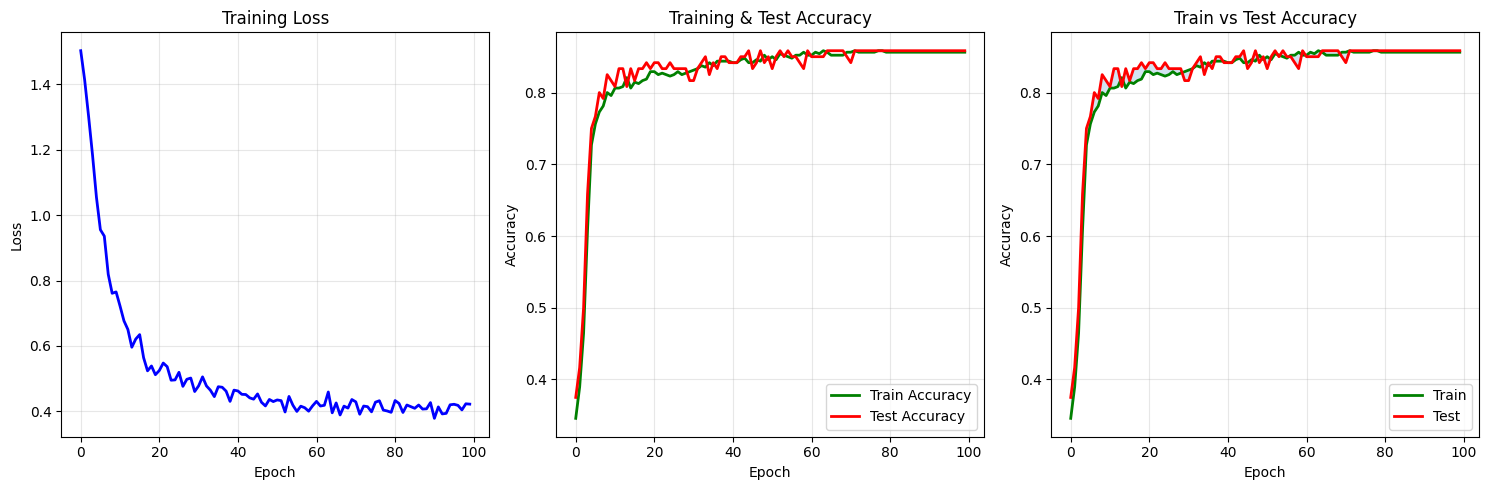


🏁 Training Finished! Final Accuracy: 85.83%


In [37]:
print("Classifying emergency vehicle siren sounds using ANN")
print("=" * 70)

# Train ANN model
model, norm_params, train_losses, train_accs, test_accs = train_ann(
    train_data, train_labels, test_data, test_labels, num_classes,
    hidden_layers=[64, 32],  # Network architecture
    learning_rate=0.01,      # Initial learning rate
    epochs=100,              # Number of training epochs
    dropout_rates=[0.3, 0.2], # Dropout for regularization
    lambd=0.001,             # L2 regularization
    batch_size=16            # Mini-batch size
)

# Evaluate model
accuracy = evaluate_ann(model, test_data, test_labels, label_map, norm_params)

# Plot training history
plot_training_history(train_losses, train_accs, test_accs)
print(f"\n🏁 Training Finished! Final Accuracy: {accuracy*100:.2f}%")

# 3.3 Save model as json

In [38]:
import json

# === SAVE MODEL ===
def save_ann_model(model, normalization_params, label_map, filename='siren_ann_model.json'):
    # Save ANN model to JSON file
    mean, std = normalization_params
    
    model_data = {
        'weights': [w.tolist() for w in model.weights],
        'biases': [b.tolist() for b in model.biases],
        'layer_sizes': model.layer_sizes,
        'dropout_rates': model.dropout_rates,
        'lambd': model.lambd,
        'normalization': {
            'mean': mean.tolist(),
            'std': std.tolist()
        },
        'label_map': label_map
    }
    
    with open(filename, 'w') as f:
        json.dump(model_data, f, indent=2)
    print(f"\n✅ Model ANN saved as: {filename}")

# Save model
save_ann_model(model, norm_params, label_map)


✅ Model ANN saved as: siren_ann_model.json
